In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
import tempfile
import os
import pandas as pd
import numpy as np
import pickle as pk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import ttest_1samp

In [14]:
# Define stoploss and take profit
stoploss = .05
takeprofit = .12
list_nPCs = [10, 15, 20, 25, 30]
fees = 0.001 # 0.1% fee structure for portfolio management

# Bring in data and define number of trades
nTrades_mini = 100 # minimal number of trades we want over the test set: this is for second approach

trainset_final = pd.read_csv('./Data_JJ/TrainSet_final_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit))
trainset = pd.read_csv('./Data_JJ/TrainSet_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit))

validation_set_final = pd.read_csv('./Data_JJ/ValidationSet_final_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit))
validation_set = pd.read_csv('./Data_JJ/ValidationSet_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit))

testset_final = pd.read_csv('./Data_JJ/TestSet_final_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit))
testset = pd.read_csv('./Data_JJ/TestSet_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit))

In [15]:
# compute wins and losses
def compute_earnings_loss(stoploss, takeprofit, fees):
    # Compute earnings and losses
    win = (1-fees)*(1+takeprofit)*(1-fees) -1
    loss = (1-fees)*(1-stoploss)*(1-fees) -1
    return(win, loss)

In [16]:
def predict_and_backtest_bullish(df, df_final, model, stoploss, takeprofit, fees, plotting = True):
    # Compute predictions on testset
    df['preds'] = (clf.predict(df_final.iloc[:, :nPCs]) > 0.5)*1
    df['proba1'] = clf.predict(df_final.iloc[:, :nPCs])

    # keep only the timesteps in which the model predicts a bullish trend
    testset1 = df[df['preds'] == 1].copy()

    # Compute earnings column
    a = compute_earnings_loss(stoploss, takeprofit, fees)
    testset1['EarningsBullish'] = (testset1['preds'] == testset1['result'])*a[0] + (testset1['preds'] != testset1['result'])*a[1]

    if plotting:
        # Now plot our trading strategy
        plt.plot(pd.to_datetime(testset1['date']), np.cumsum(testset1['EarningsBullish']))
        plt.title('Approach over the test set \n ROI = {} %'.format(100*np.mean(testset1['EarningsBullish'])))
        plt.xlabel('Date')
        plt.xlabel('Cumulative Earnings')
        plt.show()

        # Display the entry points
        plt.plot(pd.to_datetime(df['date']), df['close'])
        plt.scatter(pd.to_datetime(testset1['date']), testset1['close'], c = (testset1['EarningsBullish']>0))
        plt.title('Entry points \n Yellow = Win, Blue = Loss')
        plt.show()

    return(testset1)

In [17]:
# Hotfix function
def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

def make_keras_picklable():
    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))
    cls = Model
    cls.__reduce__ = __reduce__

# Run the function
make_keras_picklable()

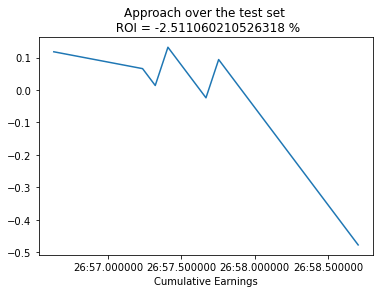

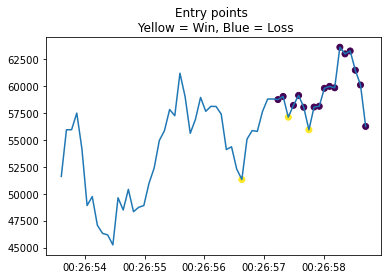

Our model has an average ROI of -2.511060210526318 %, while trading blindly bullish over the same period yielded a ROI of -1.2311677000000005 %, when we perform statistical testing of difference there is a p-value of 0.39165358887057256.


In [18]:
#################### (b) Basic strategy : pick the best model and bet on bullish trends over the testset
recap = pd.read_csv('./Results_JJ/Comparative_All_models_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit)).sort_values('Accuracy', ascending = False)
nPCs = recap['nPCs'].iloc[0]

with open("./Models_JJ/DL_model_{}PC_stoploss{}_takeprofit{}.pkl".format(nPCs, stoploss, takeprofit), 'rb') as f:
    clf = pk.load(f)

testset1 = predict_and_backtest_bullish(testset, testset_final, clf, stoploss, takeprofit, fees, plotting = True)

# Assess the performance by comparing to if we always traded bullish blindly over the period
a = compute_earnings_loss(stoploss, takeprofit, fees)
testset_benchmark = testset.copy()
testset_benchmark['EarningsBullish'] = (testset['result'] == 1)*a[0] + (testset['result'] == 0)*a[1]
avg_return_benchmark = np.mean(testset_benchmark['EarningsBullish'])

# Now let's look at our approach's performance and std
p_value = ttest_1samp(testset1['EarningsBullish'], popmean = avg_return_benchmark)[1]
print('Our model has an average ROI of {} %, while trading blindly bullish over the same period yielded a ROI of {} %, when we perform statistical testing of difference there is a p-value of {}.'.format(100*np.mean(testset1['EarningsBullish']), 100*avg_return_benchmark, p_value))

In [19]:
################### (c) More evolved strategy : look for the threshold to limit to the cases where p>a (for the best model)
def table_recap(df, stoploss, takeprofit, nPCs, columnA = 'proba1', columnB = 'EarningsBullish'):
    ''' Summarize the strategy by steps of 0.05, depending on which column (i.e. strategy)
    we choose'''
    recap = pd.DataFrame(np.zeros((int(10), 0)))
    recap['stoploss'] = stoploss
    recap['takeprofit'] = takeprofit
    recap['nPCs'] = nPCs
    recap['Min'] = [0.5 + k*0.05 for k in range(10)]
    recap['Max'] = 1
    recap['ROI%'] = 0
    recap['nTrades'] = 0
    for i in range(len(recap['Min'])):
        min, max = recap['Min'].iloc[i], recap['Max'].iloc[i]
        df2 = df[(df[columnA] > min) & (df[columnA] < max)]
        recap['ROI%'].iloc[i] = 100 * np.mean(df2[columnB])
        recap['nTrades'].iloc[i] = df2.shape[0]

    return(recap)

In [21]:
# (i) Identify best threshold
# Load best model
recap = pd.read_csv('./Results_JJ/Comparative_All_models_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit)).sort_values('Accuracy', ascending = False)
nPCs = recap['nPCs'].iloc[0]
with open("./Models_JJ/DL_model_{}PC_stoploss{}_takeprofit{}.pkl".format(nPCs, stoploss, takeprofit), 'rb') as f:
    clf = pk.load(f)

# Compute predictions on validation_set
validation_set = predict_and_backtest_bullish(validation_set, validation_set_final, clf, stoploss, takeprofit, fees, plotting = False)

# Compute recapitulative table
recap = table_recap(validation_set, stoploss, takeprofit, nPCs)
recap.to_csv('./Results_JJ/Recapitulative_result_stoploss{}_takeprofit{}_{}PCs.csv'.format(stoploss, takeprofit, nPCs), index = False)

# Pick the most profitable
recap = recap.sort_values('ROI%', ascending = False)
recap = recap[recap['nTrades'] > nTrades_mini]
print(recap)
min, max = recap['Min'].iloc[0], recap['Max'].iloc[0]

Empty DataFrame
Columns: [stoploss, takeprofit, nPCs, Min, Max, ROI%, nTrades]
Index: []


/Users/jacobjalomo/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/jacobjalomo/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/jacobjalomo/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

IndexError: single positional indexer is out-of-bounds